# Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import os

import pandas as pd
import numpy as np

from glob import glob
from PIL import Image
import cv2

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Model, Sequential
from keras.optimizers import Adam
import kerastuner as kt
from keras.applications import (
    ResNet50,
    InceptionV3,
    DenseNet121,
    VGG16,
    Xception)

import warnings
warnings.filterwarnings('ignore')


from utils import *

C:\Users\Afonso Cadete\AppData\Local\Temp\ipykernel_22244\897963344.py:29: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


# Import Data

In [ ]:
# Set the base directory to location #change
project_path = 'C:\\Users\\marcelo\\Documents\\ProjectDataDL\\DeepLearning' # Marcelo
# project_path = 'C:\\Users\\Afonso Cadete\\Documents\\Projects Data\\Deep Learning' # Afonso
# project_path = 'C:\\Users\\Martin\\OneDrive - NOVAIMS\\Documents\\Universidade\\3º Ano\\Deep Learning\\Project' #Martim

# Merge images from both folders train and test into one dictionary
images_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(project_path, '*', '*.jpg'))}

# Read the metadata CSV file from directory
metadata = pd.read_csv(os.path.join(project_path, 'HAM10000_metadata.csv'))

# Create new columns for better readability #change
metadata['path'] = metadata['image_id'].map(images_path_dict.get)

# Convert image paths to NumPy arrays with RGB channels
metadata['image'] = metadata['path'].map(lambda x: np.asarray(Image.open(x))) # RGB + faster than cv2.imread

# Create train and test dataframes
train_data = metadata[metadata['path'].str.contains('train')]
test_data = metadata[metadata['path'].str.contains('test')]

In [3]:
# # Delete unnecessary columns
# train_data.drop(columns=['lesion_id', 'image_id', 'path'], inplace=True)
# test_data.drop(columns=['lesion_id', 'image_id', 'path'], inplace=True)

# EDA

## Train percentage of Data

In [4]:
train_percentage(metadata, train_data)

Train represents 75.0%


## Missing Values

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7511 entries, 0 to 10014
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     7511 non-null   object 
 1   image_id      7511 non-null   object 
 2   dx            7511 non-null   object 
 3   dx_type       7511 non-null   object 
 4   age           7467 non-null   float64
 5   sex           7511 non-null   object 
 6   localization  7511 non-null   object 
 7   path          7511 non-null   object 
 8   image         7511 non-null   object 
dtypes: float64(1), object(8)
memory usage: 586.8+ KB


In [6]:
missing_values_percentage(train_data, 'age')

Percentage of "age" missing values: 0.59%


## Variable Distributions

### Numerical features

In [7]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,7467.0,51.7122,16.944405,0.0,40.0,50.0,65.0,85.0


#### `age`

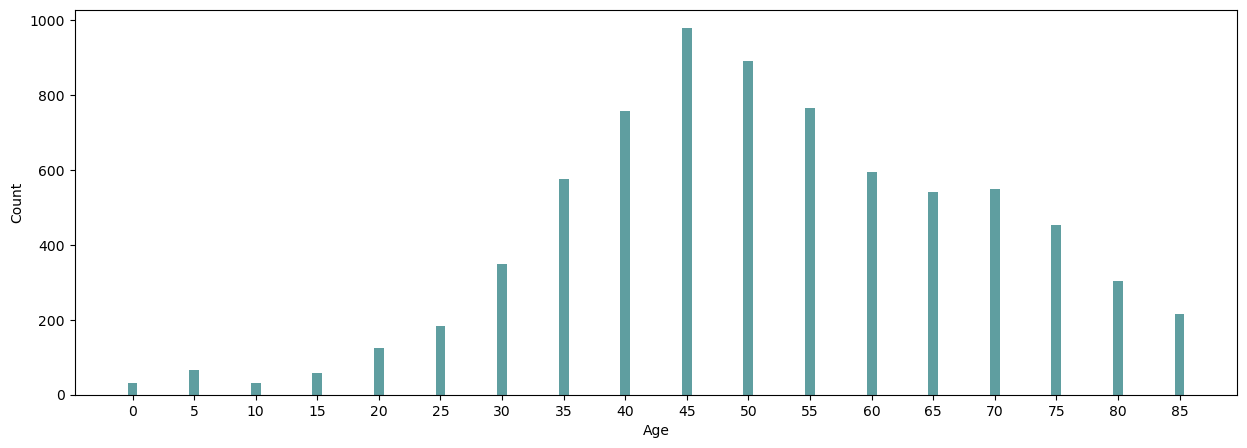

In [8]:
fig, ax = plt.subplots()
plot_bar_chart(ax, train_data, 'age', 'Age')

### Categorical features

In [9]:
train_data.iloc[:,:-1].describe(exclude=['number']).T

,count,unique,top,freq
lesion_id,7511,5998,HAM_0005263,6
image_id,7511,7511,ISIC_0027419,1
dx,7511,7,nv,5029
dx_type,7511,4,histo,4014
sex,7511,3,male,4052
localization,7511,15,back,1634
path,7511,7511,C:\Users\Afonso Cadete\Documents\Projects Data...,1


#### `dx` --- target

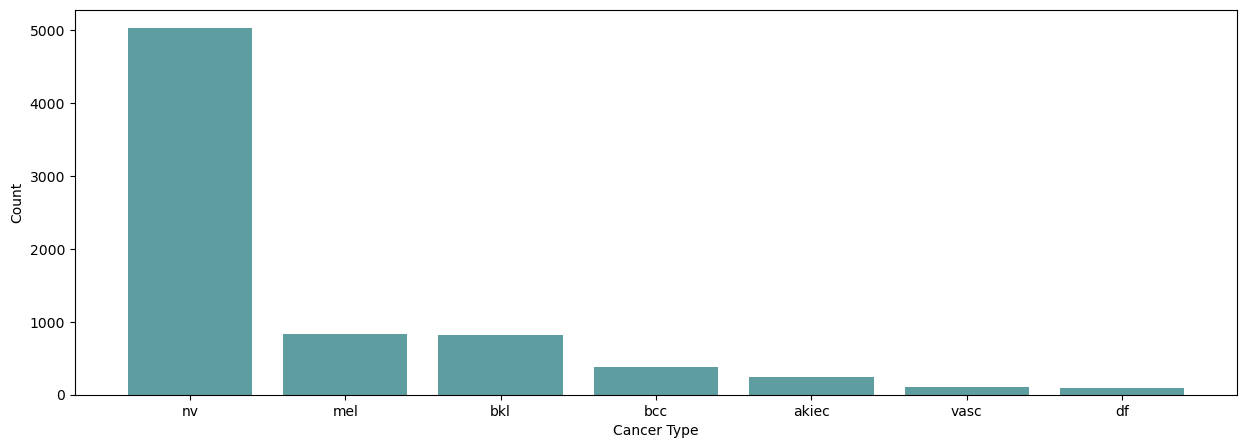

In [10]:
fig, ax = plt.subplots()
plot_bar_chart(ax, train_data, 'dx', 'Cancer Type')

#### `dx_type`

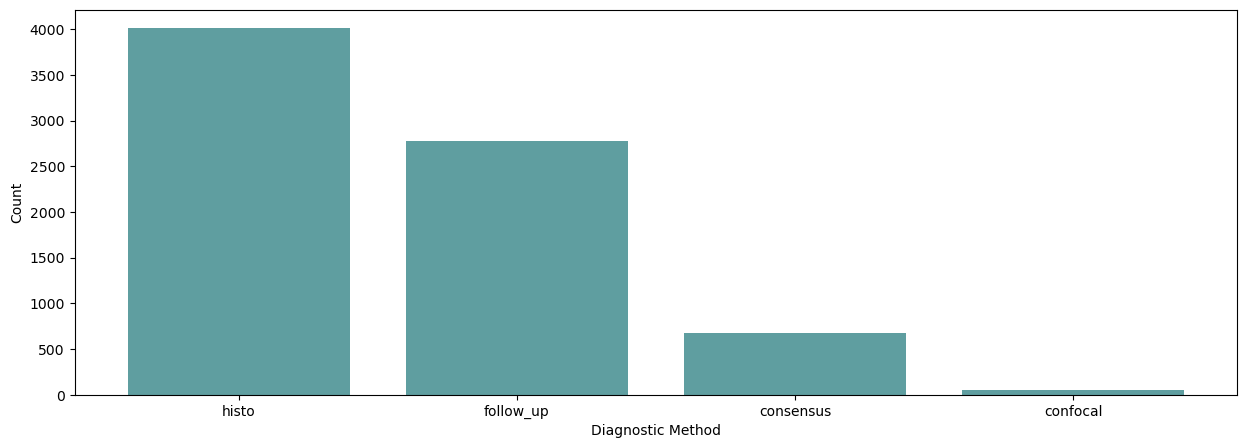

In [11]:
fig, ax = plt.subplots()
plot_bar_chart(ax, train_data, 'dx_type', 'Diagnostic Method')

#### `sex`

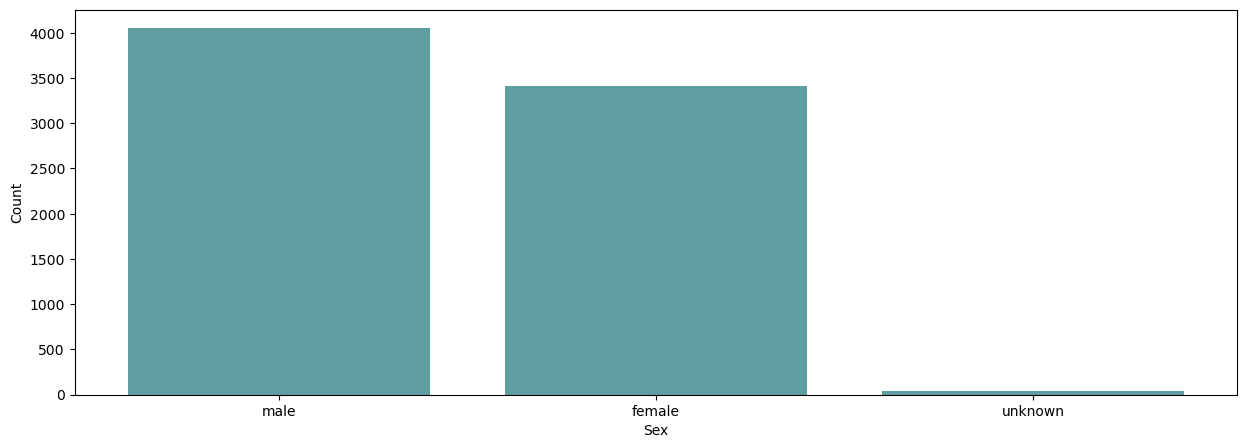

In [12]:
fig, ax = plt.subplots()
plot_bar_chart(ax, train_data, 'sex', 'Sex')

#### `localization`

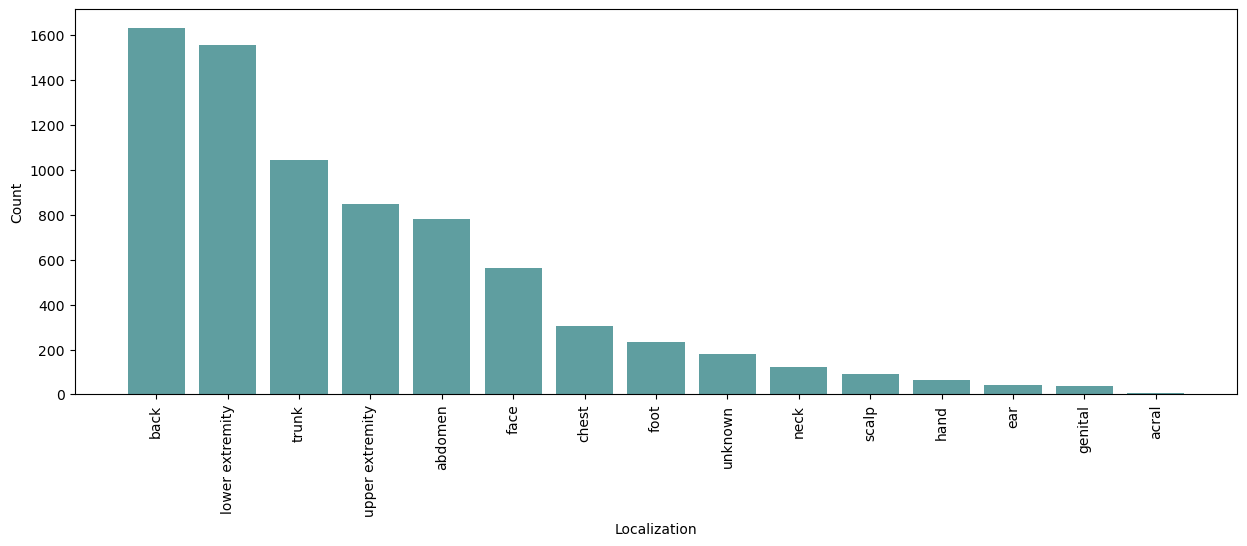

In [13]:
fig, ax = plt.subplots()
plt.xticks(rotation=90)
plot_bar_chart(ax, train_data, 'localization', 'Localization')

## Variable's `image` Structure

In [14]:
train_data['image'].map(lambda x: x.shape).value_counts() # height, width, channels

(450, 600, 3)    7511
Name: image, dtype: int64

## Duplicates

In [15]:
train_data['lesion_id'].duplicated().sum()

1513

In [16]:
train_data.iloc[:,:7].drop('image_id', axis=1).duplicated().sum()

1512

In [17]:
train_data[train_data['lesion_id'] == 'HAM_0001726'] # cancer spread (?)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,image
1248,HAM_0001726,ISIC_0024367,mel,histo,35.0,female,back,C:\Users\Afonso Cadete\Documents\Projects Data...,"[[[51, 40, 38], [56, 40, 41], [58, 42, 45], [6..."
2008,HAM_0001726,ISIC_0024700,mel,histo,35.0,female,trunk,C:\Users\Afonso Cadete\Documents\Projects Data...,"[[[217, 138, 141], [219, 140, 145], [217, 137,..."


In [18]:
# train_data.drop_duplicates(subset='lesion_id', keep='first', inplace=True)

## Data Preprocessing

In [19]:
# Create a copy of the dataset for the sake of safety
train = train_data.copy()
# train = train_data.sample(frac=0.5, random_state=21) # if you want to sample the dataset

In [20]:
# train_metadata = train[['dx_type', 'age', 'sex', 'localization']]

### Data Preparation

In [21]:
# Create a list with all values of each image
X_train = np.asarray(train['image'].tolist())
X_train

array([[[[188, 147, 191],
         [186, 148, 189],
         [187, 150, 191],
         ...,
         [196, 155, 171],
         [197, 156, 170],
         [197, 157, 168]],

        [[186, 149, 193],
         [187, 152, 194],
         [189, 153, 191],
         ...,
         [194, 156, 169],
         [195, 159, 169],
         [192, 159, 168]],

        [[185, 148, 192],
         [189, 152, 195],
         [190, 153, 196],
         ...,
         [196, 155, 169],
         [198, 157, 171],
         [194, 156, 169]],

        ...,

        [[157, 124, 155],
         [156, 121, 154],
         [159, 124, 154],
         ...,
         [177, 146, 161],
         [176, 144, 159],
         [175, 141, 155]],

        [[155, 122, 151],
         [156, 123, 154],
         [156, 123, 152],
         ...,
         [178, 147, 163],
         [175, 144, 159],
         [175, 142, 159]],

        [[154, 119, 151],
         [153, 120, 149],
         [154, 121, 152],
         ...,
         [176, 147, 167],
        

In [22]:
# Convert the target to a categorical feature and one-hot encode it
y_train = pd.Categorical(train['dx']).codes
# y_train = to_categorical(y_train, num_classes=7)
y_train

array([2, 2, 2, ..., 0, 0, 4], dtype=int8)

### Compute Class Weights

### Image Enhancement

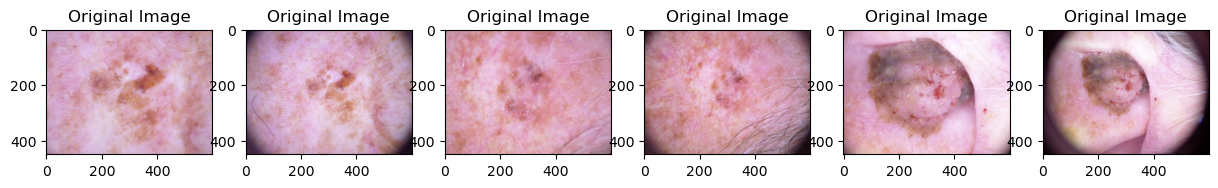

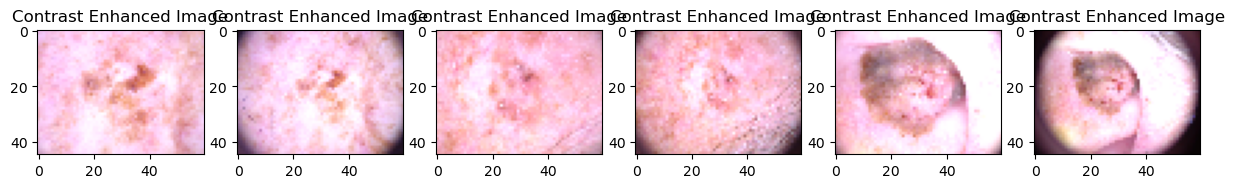

In [23]:
X_train_processed = apply_contrast_enhancement(X_train, size=(60, 45), alpha=1.2, beta=4, display=True)

### Scaling

In [24]:
X_train_scaled = X_train_processed / 255

### Data Partition

In [29]:
partial_X_train, X_val, partial_y_train, y_val = train_test_split(X_train_scaled, y_train, 
                                                                   test_size=0.2, random_state=42,
                                                                   stratify=y_train, shuffle=True)

# Modelling

In [25]:
# ##### CONV-POOLING SEQUENCES #####
# model = Sequential()

# model.add(Conv2D(20, kernel_size=(3,3), padding='same', activation='relu', input_shape=(45,60,3)))
# # model.add(MaxPooling2D((3,3)))

# model.add(Conv2D(40, kernel_size=(3,3), padding='same', activation='relu'))
# # model.add(MaxPooling2D((3,3)))

# model.add(Conv2D(60, kernel_size=(3,3), padding='same', activation='relu'))
# model.add(MaxPooling2D((3,3)))
# model.add(Dropout(0.3))

# # model.add(Conv2D(80, kernel_size = (2, 2), padding='same', activation = 'relu'))
# # model.add(MaxPooling2D((2,2)))

# model.add(Conv2D(20, kernel_size=(3,3), padding='same', activation='relu'))
# # model.add(MaxPooling2D((3,3)))

# model.add(Conv2D(40, kernel_size=(3,3), padding='same', activation='relu'))
# # model.add(MaxPooling2D((3,3)))

# model.add(Conv2D(60, kernel_size=(3,3), padding='same', activation='relu'))
# model.add(MaxPooling2D((3,3)))
# model.add(Dropout(0.3))

# model.add(Flatten())

# model.add(Dense(258, activation='relu'
#                 ))
# model.add(Dropout(0.3))

# model.add(Dense(124, activation='relu'
#                 ))
# model.add(Dropout(0.3))

# model.add(Dense(7, activation='softmax'))

In [26]:
##### MANY CONV SEQUENCES #####

In [30]:
# ##### BASED ON GRID SEARCH #####
# model = Sequential()

# model.add(Conv2D(40, kernel_size=(3,3), padding='same', activation='relu', input_shape=(45,60,3)))
# model.add(MaxPooling2D((3,3)))
# model.add(Dropout(0.2))

# model.add(Conv2D(80, kernel_size=(3,3), padding='same', activation='relu'))
# model.add(MaxPooling2D((3,3)))
# model.add(Dropout(0.2))

# model.add(Flatten())

# model.add(Dense(140, activation='relu', #kernel_regularizer=keras.regularizers.l2(0.001)
#                 ))
# model.add(Dropout(0.2))

# model.add(Dense(70, activation='relu', #kernel_regularizer=keras.regularizers.l2(0.001)
#                 ))
# model.add(Dropout(0.2))

# model.add(Dense(7, activation='softmax'))

# # RESULTS ---> TRAIN: 0.81 - VAL: 0.75

# Stratified K-Fold

In [67]:
# Define inputs and targets
inputs = X_train_scaled
targets = y_train

# Define per-fold metric containers
acc_per_fold = []
loss_per_fold = []
train_f1_scores = []
test_f1_scores = []
class_train_f1_scores = {i: [] for i in range(7)}
class_test_f1_scores = {i: [] for i in range(7)}
train_losses = []
val_losses = []


# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

    # Define the model architecture
    model = None
    model = Sequential()

    model.add(Conv2D(20, kernel_size=(2,2), padding='same', activation='relu', input_shape=(45, 60, 3)))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(40, kernel_size=(2,2), padding='same', activation='relu'))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(60, kernel_size=(2,2), padding='same', activation='relu'))
    model.add(MaxPooling2D((2,2)))

    # model.add(Conv2D(80, kernel_size=(2,2), padding='same', activation='relu'))
    # model.add(MaxPooling2D((2,2)))

    model.add(Flatten())

    model.add(Dense(258, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(124, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(7, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

    # Generate a print for better visualization
    print('---------------------------------------------------------------------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(inputs[train], targets[train], batch_size=512,
                        validation_data=(inputs[test], targets[test]),
                        epochs=50, verbose=1, callbacks=[early_stopping])

    # Generate generalization metrics
    train_pred = np.argmax(model.predict(X_train_scaled[train]), axis=1)
    test_pred = np.argmax(model.predict(X_train_scaled[test]), axis=1)

    # Classification reports
    train_report = classification_report(y_train[train], train_pred, output_dict=True)
    test_report = classification_report(y_train[test], test_pred, output_dict=True)

    # Calculate and store F1-scores
    train_f1_weighted = train_report['weighted avg']['f1-score']
    test_f1_weighted = test_report['weighted avg']['f1-score']

    # Append scores to lists
    train_f1_scores.append(train_f1_weighted)
    test_f1_scores.append(test_f1_weighted)

    for i in range(7):
        class_train_f1_scores[i].append(train_report[str(i)]['f1-score'])
        class_test_f1_scores[i].append(test_report[str(i)]['f1-score'])

    # Append train and validation losses to lists
    train_losses.append(history.history['loss'][-1])
    val_losses.append(history.history['val_loss'][-1])

    # Next fold
    fold_no += 1

# Provide average and standard deviation scores for all folds
avg_train_f1_score = np.mean(train_f1_scores)
std_train_f1_score = np.std(train_f1_scores)
avg_val_f1_score = np.mean(test_f1_scores)
std_val_f1_score = np.std(test_f1_scores)

# Calculate mean and standard deviation of train and validation losses
avg_train_loss = np.mean(train_losses)
std_train_loss = np.std(train_losses)
avg_val_loss = np.mean(val_losses)
std_val_loss = np.std(val_losses)

print('---------------------------------------------------------------------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Average Train F1-score (weighted): {avg_train_f1_score:.2f} (+- {std_train_f1_score:.2f})')
print(f'> Average Validation F1-score (weighted): {avg_val_f1_score:.2f} (+- {std_val_f1_score:.2f})')
print(f'> Average Train Loss: {avg_train_loss:.4f} (+- {std_train_loss:.4f})')
print(f'> Average Validation Loss: {avg_val_loss:.4f} (+- {std_val_loss:.4f})')
print('---------------------------------------------------------------------------------------------------------------------------------------')

# Calculate mean and std for train and validation F1-scores per class
class_f1_scores = {}
for i in range(7):
    train_mean = np.round(np.mean(class_train_f1_scores[i]), 2)
    train_std = np.round(np.std(class_train_f1_scores[i]), 3)
    val_mean = np.round(np.mean(class_test_f1_scores[i]), 2)
    val_std = np.round(np.std(class_test_f1_scores[i]), 3)
    
    class_f1_scores[i] = {
        'Train': f'{train_mean} (+/- {train_std})',
        'Validation': f'{val_mean} (+/- {val_std})'
    }

# Create a DataFrame with the results
results = pd.DataFrame.from_dict(class_f1_scores, orient='index')

# Display the DataFrame
print('Average scores per class:')
print(results)

---------------------------------------------------------------------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
14/14 [==============================] - 5s 255ms/step - loss: 1.2943 - accuracy: 0.6340 - val_loss: 1.0803 - val_accuracy: 0.6689
Epoch 2/50
14/14 [==============================] - 3s 246ms/step - loss: 1.0936 - accuracy: 0.6692 - val_loss: 1.0013 - val_accuracy: 0.6689
Epoch 3/50
14/14 [==============================] - 3s 247ms/step - loss: 1.0323 - accuracy: 0.6696 - val_loss: 0.9587 - val_accuracy: 0.6689
Epoch 4/50
14/14 [==============================] - 3s 228ms/step - loss: 0.9866 - accuracy: 0.6695 - val_loss: 0.9243 - val_accuracy: 0.6689
Epoch 5/50
14/14 [==============================] - 3s 234ms/step - loss: 0.9525 - accuracy: 0.6715 - val_loss: 0.9119 - val_accuracy: 0.6822
Epoch 6/50
14/14 [==============================] - 3s 243ms/step - loss: 0.9205 - accuracy: 0.6770 - val_loss: 0.9140 - val_accur

In [68]:
# # Plot the loss for each fold in respect for the number of epochs it has trained
# # Define the figure and axes
# fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# # Plot the loss for each fold
# for fold, ax in enumerate(axes.flat):
#   ax.plot(range(len(train_losses[fold])), train_losses[fold], label=f'Fold {fold+1}')
#   ax.set_xlabel('Epoch')
#   ax.set_ylabel('Loss')
#   ax.legend()

# # Tighten the layout
# fig.tight_layout()

# # Save the figure as a single image with four subplots

# Grid Search

In [48]:
# def build_model(hp):
#   """
#   Builds model and sets up hyperparameter space to search.

#   Parameters
#   ----------
#   hp : HyperParameter object
#       Configures hyperparameters to tune.

#   Returns
#   -------
#   model : keras model
#       Compiled model with hyperparameters to tune.
#   """
#   # Initialize sequential API and start building model.
#   model = keras.Sequential()

#   for i in range(1, hp.Int('image_num_layers', 1, 5, step=1) + 1):  ## The basic for loop for including several layers
#       model.add(
#           keras.layers.Conv2D(
#               filters=hp.Int('image_filters_' + str(i), min_value=10, max_value=80, step=10),
#               kernel_size=(2,2), padding='same', activation='relu')
#           )
#       # Dropout followin the previous dense layer means that after each layer we would have a dropout
#       # Tune dropout layer with values from 0 - 0.3 with stepsize of 0.1.
#       model.add(keras.layers.MaxPooling2D((2,2)))

#   model.add(keras.layers.Flatten())

#   # Tune the number of hidden layers and units in each.
#   # Number of hidden layers: 1 - 5
#   # Number of Units: 32 - 512 with stepsize of 32
#   for i in range(1, hp.Int('dense_num_layers', 1, 5) + 1):  ## The basic for loop for including several layers
#       model.add(
#           keras.layers.Dense(
#               units=hp.Int('dense_units_' + str(i), min_value=32, max_value=512, step=32),
#               activation='relu')
#           )
#       # Dropout followin the previous dense layer means that after each layer we would have a dropout
#       # Tune dropout layer with values from 0 - 0.3 with stepsize of 0.1.
#       model.add(keras.layers.Dropout(hp.Float('dropout_' + str(i), 0, 0.5, step=0.1)))

#   # Add output layer.
#   model.add(keras.layers.Dense(units=7, activation='softmax'))

#   # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
#   hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#   # Define optimizer, loss, and metrics
#   model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                 loss=keras.losses.SparseCategoricalCrossentropy(),
#                 metrics=['accuracy'])

#   return model

In [49]:
# # Instantiate the tuner
# tuner = kt.GridSearch(build_model, # the hypermodel
#                      objective='val_loss',  # Our main monitoring metric
#                      max_trials=50,  # Max numbers of iteration before stoppin
# )

In [50]:
# tuner.search_space_summary()

Search space summary
Default search space size: 6
image_num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
image_filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 80, 'step': 10, 'sampling': 'linear'}
dense_num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
dense_units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [51]:
# # stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# tuner.search(partial_X_train, partial_y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stop])

Trial 50 Complete [00h 05m 37s]
val_loss: 0.7380521893501282

Best val_loss So Far: 0.7161464691162109
Total elapsed time: 03h 32m 49s


In [52]:
# tuner.get_best_hyperparameters()[0].values

{'image_num_layers': 1,
 'image_filters_1': 10,
 'dense_num_layers': 1,
 'dense_units_1': 96,
 'dropout_1': 0.1,
 'learning_rate': 0.0001}